In [ ]:
!pip install timm
!pip install ndlinear

In [ ]:
# Clean reinstall of sympy + torchvision dependencies
!pip uninstall -y sympy torchvision torch
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install sympy==1.13.1


Found existing installation: sympy 1.13.1
Uninstalling sympy-1.13.1:
  Successfully uninstalled sympy-1.13.1
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 110.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00

In [ ]:
import torch
import sympy
from torchvision import datasets, transforms
print("✅ Torch:", torch.__version__)
print("✅ Sympy:", sympy.__version__)


✅ Torch: 2.5.1+cu121
✅ Sympy: 1.13.1


In [ ]:
import torch
import torch.nn as nn
# from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from ndlinear import NdLinear
import timm
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
from torchvision.transforms import ToTensor, Resize, Compose, Lambda

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Lambda(lambda x: x.repeat(3, 1, 1))  # Grayscale → RGB by repeating channels
])


train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [ ]:
import timm
from ndlinear import NdLinear

class SmallViT(nn.Module):
    def __init__(self, use_ndlinear=False):
        super().__init__()
        self.model = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=10)
        if use_ndlinear:
            self._replace_linear_with_nd(self.model)

    def _replace_linear_with_nd(self, module):
        for name, child in module.named_children():
            if isinstance(child, nn.Linear):
                in_f, out_f = child.in_features, child.out_features
                setattr(module, name, NdLinear(input_dims=(in_f, 1), hidden_size=(out_f, 1)))
            else:
                self._replace_linear_with_nd(child)

    def forward(self, x):
        return self.model(x)

# Load models (one at a time to conserve memory)
model1 = SmallViT(use_ndlinear=False).to(device)  # Set to True to test NdLinear


In [ ]:
import time
import torch
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

def train_and_compare(model, train_loader, test_loader, epochs=3, lr=3e-4):
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CrossEntropyLoss()

    train_loss_history = []
    val_loss_history = []
    accuracy_history = []
    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"🔍 Trainable Parameters: {param_count:,}")
    print(f"📦 Approx. Model Size: {param_count * 4 / 1e6:.2f} MB\n")

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        total = 0
        start_time = time.time()

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        end_time = time.time()
        val_accuracy = 100 * correct / total

        train_loss_history.append(total_loss / len(train_loader))
        val_loss_history.append(val_loss / len(test_loader))
        accuracy_history.append(val_accuracy)

        print(f"🧪 Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {total_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Accuracy: {val_accuracy:.2f}% | "
              f"Time: {end_time - start_time:.2f}s")

    # Plot loss
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        "params": param_count,
        "final_train_loss": train_loss_history[-1],
        "final_val_loss": val_loss_history[-1],
        "final_accuracy": accuracy_history[-1]
    }


In [ ]:
from ndlinear import NdLinear
import timm
import torch.nn as nn

class NdLinearAdapter(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.nd = NdLinear(input_dims=(in_features, 1), hidden_size=(out_features, 1))

    def forward(self, x):
        if x.dim() == 2:
            # [B, D] → [B, D, 1] → Nd → [B, O]
            x = self.nd(x.unsqueeze(-1)).squeeze(-1)
        elif x.dim() == 3:
            # [B, N, D] → [B*N, D, 1] → Nd → [B, N, O]
            B, N, D = x.shape
            x = self.nd(x.view(B * N, D, 1)).view(B, N, -1)
        else:
            raise ValueError("Unsupported input shape for NdLinearAdapter.")
        return x


# ViT model with optional NdLinear swap
class SmallViT(nn.Module):
    def __init__(self, use_ndlinear=False):
        super().__init__()
        self.model = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=10)
        if use_ndlinear:
            self._replace_linear_with_nd(self.model)

    def _replace_linear_with_nd(self, module):
        for name, child in module.named_children():
            if isinstance(child, nn.Linear):
                in_f, out_f = child.in_features, child.out_features
                setattr(module, name, NdLinearAdapter(in_f, out_f))
            else:
                self._replace_linear_with_nd(child)

    def forward(self, x):
        return self.model(x)


🔍 Trainable Parameters: 5,526,346
📦 Approx. Model Size: 22.11 MB

🧪 Epoch [1/5] | Train Loss: 979.4062 | Val Loss: 63.5947 | Accuracy: 86.72% | Time: 271.60s
🧪 Epoch [2/5] | Train Loss: 315.7403 | Val Loss: 36.6526 | Accuracy: 92.06% | Time: 273.15s
🧪 Epoch [3/5] | Train Loss: 221.5308 | Val Loss: 36.0268 | Accuracy: 92.82% | Time: 273.38s
🧪 Epoch [4/5] | Train Loss: 183.0749 | Val Loss: 26.3707 | Accuracy: 94.71% | Time: 273.23s
🧪 Epoch [5/5] | Train Loss: 160.3548 | Val Loss: 22.0806 | Accuracy: 95.46% | Time: 271.89s


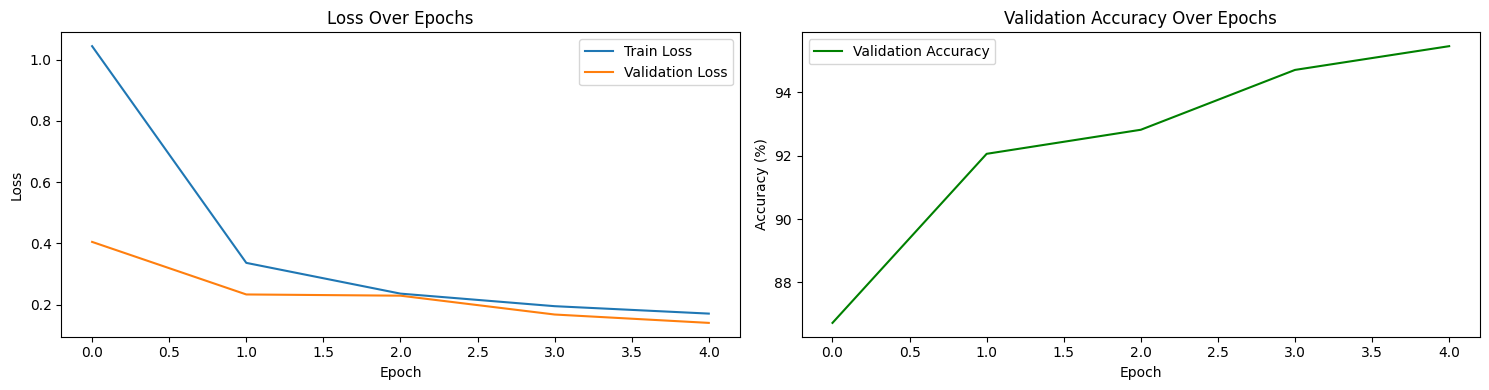

{'params': 5526346,
 'final_train_loss': 0.17095398063709868,
 'final_val_loss': 0.14064077582732318,
 'final_accuracy': 95.46}

In [ ]:
baseline_model = SmallViT(use_ndlinear=False).to(device)
train_and_compare(baseline_model, train_loader, test_loader, epochs=5)

🔍 Trainable Parameters: 5,526,444
📦 Approx. Model Size: 22.11 MB

🧪 Epoch [1/5] | Train Loss: 838.7290 | Val Loss: 51.5445 | Accuracy: 89.98% | Time: 391.87s
🧪 Epoch [2/5] | Train Loss: 246.3365 | Val Loss: 42.3249 | Accuracy: 91.97% | Time: 392.41s
🧪 Epoch [3/5] | Train Loss: 178.5027 | Val Loss: 24.1596 | Accuracy: 95.12% | Time: 391.77s
🧪 Epoch [4/5] | Train Loss: 150.2428 | Val Loss: 23.1145 | Accuracy: 95.57% | Time: 391.02s
🧪 Epoch [5/5] | Train Loss: 130.7451 | Val Loss: 23.4269 | Accuracy: 95.58% | Time: 391.10s


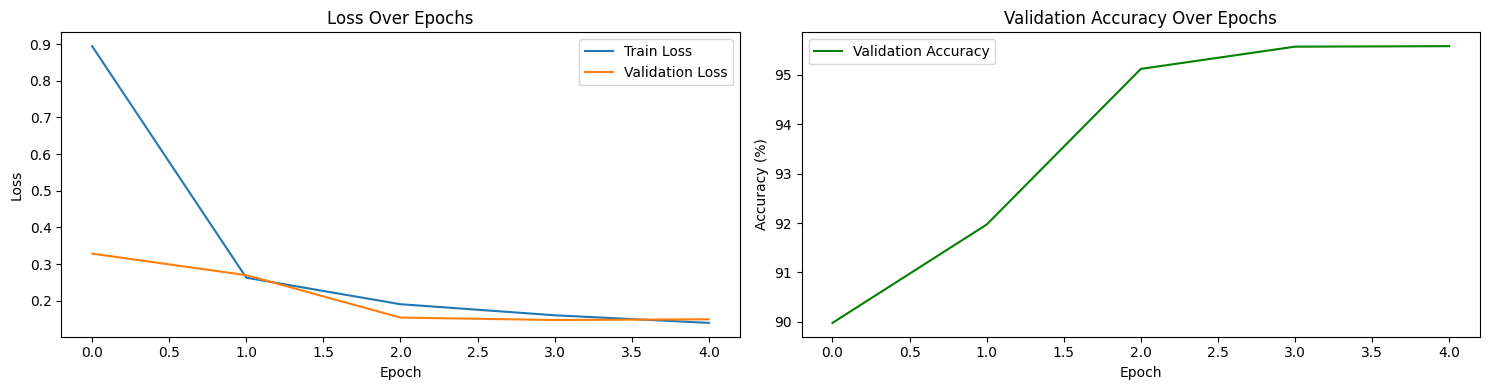

{'params': 5526444,
 'final_train_loss': 0.1393871510059817,
 'final_val_loss': 0.14921571867196423,
 'final_accuracy': 95.58}

In [ ]:
ndlinear_model = SmallViT(use_ndlinear=True).to(device)
train_and_compare(ndlinear_model, train_loader, test_loader, epochs=5)